In [34]:
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns 
from pydataset import data 

import matplotlib.pyplot as plt

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_the_baseline, rfe, select_kbest
from wrangle import split_data

In [2]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

## Modeling: Regression Exercise

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [3]:
iris_df = data('iris')

In [4]:
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


#### Looking at data types of columns

In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


#### Looking at categorical variable value counts

In [6]:
iris_df.Species.value_counts()

setosa        50
versicolor    50
virginica     50
Name: Species, dtype: int64

#### Taking a look at variable distributions

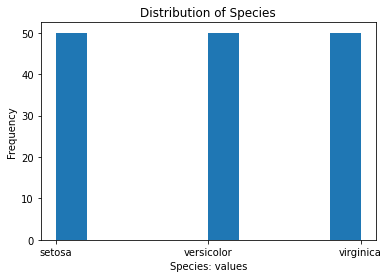

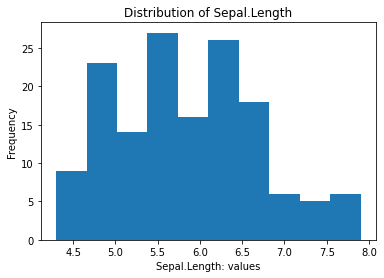

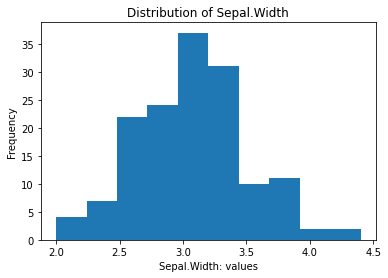

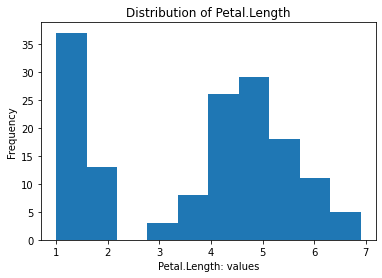

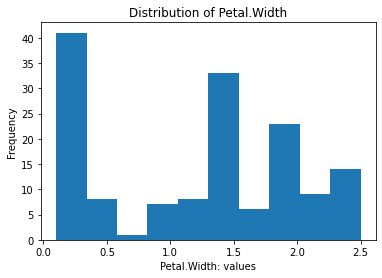

In [7]:
cols = ['Species', 'Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
    
for col in iris_df[cols]:
    plt.hist(iris_df[col])
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(f'{col}: values')
    plt.show()

In [8]:
iris_df = iris_df.rename(columns = {'Petal.Length': 'petal_length'})

#### Changing column names

In [9]:
iris_df = iris_df.rename(columns = {'Petal.Width': 'petal_width'})
iris_df = iris_df.rename(columns = {'Sepal.Length': 'sepal_length'})
iris_df = iris_df.rename(columns = {'Sepal.Width': 'sepal_width'})

In [10]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [11]:
iris_df = iris_df.rename(columns = {'Species': 'species_type'})

In [12]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species_type
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


#### Changing categorical variable column to seperate boolean columns

In [13]:
iris_df['is_setosa'] = np.where(iris_df.species_type == 'setosa', 1, 0)
iris_df['is_virginica'] = np.where(iris_df.species_type == 'virginica', 1, 0)
iris_df['is_versicolor'] = np.where(iris_df.species_type == 'versicolor', 1, 0)

In [14]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species_type,is_setosa,is_virginica,is_versicolor
1,5.1,3.5,1.4,0.2,setosa,1,0,0
2,4.9,3.0,1.4,0.2,setosa,1,0,0
3,4.7,3.2,1.3,0.2,setosa,1,0,0
4,4.6,3.1,1.5,0.2,setosa,1,0,0
5,5.0,3.6,1.4,0.2,setosa,1,0,0


In [15]:
iris_df = iris_df.drop(columns = 'species_type')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,is_setosa,is_virginica,is_versicolor
1,5.1,3.5,1.4,0.2,1,0,0
2,4.9,3.0,1.4,0.2,1,0,0
3,4.7,3.2,1.3,0.2,1,0,0
4,4.6,3.1,1.5,0.2,1,0,0
5,5.0,3.6,1.4,0.2,1,0,0


In [16]:
iris_df['sepal_area'] = iris_df.sepal_width * iris_df.sepal_length
iris_df['petal_area'] = iris_df.petal_width * iris_df.sepal_area

#### Time to Prepare

##### Splitting the data

In [18]:
train, validate, test = split_data(iris_df)
train.shape, validate.shape, test.shape

((84, 10), (36, 10), (30, 10))

In [19]:
train.head()

,sepal_length,sepal_width,petal_length,petal_width,is_setosa,is_virginica,is_versicolor,sepal_area,petal_area,baseline
57,6.3,3.3,4.7,1.6,0,0,1,20.79,33.264,3.758
41,5.0,3.5,1.3,0.3,1,0,0,17.50,5.250,3.758
71,5.9,3.2,4.8,1.8,0,0,1,18.88,33.984,3.758
24,5.1,3.3,1.7,0.5,1,0,0,16.83,8.415,3.758
140,6.9,3.1,5.4,2.1,0,1,0,21.39,44.919,3.758


In [20]:
validate.head()

,sepal_length,sepal_width,petal_length,petal_width,is_setosa,is_virginica,is_versicolor,sepal_area,petal_area,baseline
63,6.0,2.2,4.0,1.0,0,0,1,13.20,13.200,3.758
67,5.6,3.0,4.5,1.5,0,0,1,16.80,25.200,3.758
124,6.3,2.7,4.9,1.8,0,1,0,17.01,30.618,3.758
112,6.4,2.7,5.3,1.9,0,1,0,17.28,32.832,3.758
125,6.7,3.3,5.7,2.1,0,1,0,22.11,46.431,3.758


In [21]:
test.head()

,sepal_length,sepal_width,petal_length,petal_width,is_setosa,is_virginica,is_versicolor,sepal_area,petal_area,baseline
73,6.3,2.5,4.9,1.5,0,0,1,15.75,23.625,3.758
113,6.8,3.0,5.5,2.1,0,1,0,20.40,42.840,3.758
133,6.4,2.8,5.6,2.2,0,1,0,17.92,39.424,3.758
89,5.6,3.0,4.1,1.3,0,0,1,16.80,21.840,3.758
38,4.9,3.6,1.4,0.1,1,0,0,17.64,1.764,3.758


#### Petal Length will be our target variable
##### Setting up X and Y splits

In [22]:
X_train, y_train = train.drop(columns = ['petal_length', 'petal_area']), train.petal_length
X_validate, y_validate = validate.drop(columns = ['petal_length', 'petal_area']), validate.petal_length
X_test, y_test = test.drop(columns = ['petal_length', 'petal_area']), test.petal_length

In [23]:
X_train.head()

,sepal_length,sepal_width,petal_width,is_setosa,is_virginica,is_versicolor,sepal_area,baseline
57,6.3,3.3,1.6,0,0,1,20.79,3.758
41,5.0,3.5,0.3,1,0,0,17.50,3.758
71,5.9,3.2,1.8,0,0,1,18.88,3.758
24,5.1,3.3,0.5,1,0,0,16.83,3.758
140,6.9,3.1,2.1,0,1,0,21.39,3.758


#### Scaling our data using a min max scaler

In [24]:
_, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, 
                                                                  X_validate, 
                                                                  X_test)

In [25]:
X_train_scaled.head()

,sepal_length,sepal_width,petal_width,is_setosa,is_virginica,is_versicolor,sepal_area,baseline
57,0.529412,0.65,0.625000,0.0,0.0,1.0,0.538961,0.0
41,0.147059,0.75,0.083333,1.0,0.0,0.0,0.374625,0.0
71,0.411765,0.60,0.708333,0.0,0.0,1.0,0.443556,0.0
24,0.176471,0.65,0.166667,1.0,0.0,0.0,0.341159,0.0
140,0.705882,0.55,0.833333,0.0,1.0,0.0,0.568931,0.0


#### Using our functions to select the best features to predict our target variable

In [26]:
select_kbest(X_train, y_train, 2)

Index(['petal_width', 'is_setosa'], dtype='object')

In [27]:
rfe(X_train, y_train, 2)

Index(['is_virginica', 'is_versicolor'], dtype='object')

In [29]:
y_train.head()

57     4.7
41     1.3
71     4.8
24     1.7
140    5.4
Name: petal_length, dtype: float64

(array([16., 10.,  0.,  1.,  6., 10., 15., 12., 10.,  4.]),
 array([1.  , 1.57, 2.14, 2.71, 3.28, 3.85, 4.42, 4.99, 5.56, 6.13, 6.7 ]),
 <BarContainer object of 10 artists>)

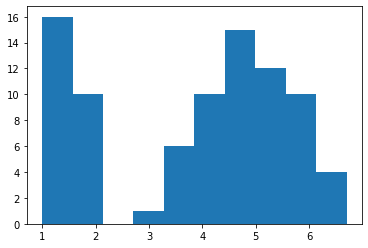

In [28]:
plt.hist(y_train)

#### Setting up our baseline

In [42]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

petal_length_pred_mean = y_train.petal_length.mean()
y_train['petal_length_pred_mean'] = petal_length_pred_mean
y_validate['petal_length_pred_mean'] = petal_length_pred_mean


petal_length_pred_median = y_train.petal_length.median()
y_train['petal_length_pred_median'] = petal_length_pred_median
y_validate['petal_length_pred_median'] = petal_length_pred_median

In [33]:
rmse_train = mean_squared_error(y_train.petal_length, y_train.petal_length_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.petal_length, y_validate.petal_length_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  1.71 
Validate/Out-of-Sample:  1.75


In [39]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.petal_length, y_validate.petal_length_pred_mean)}])


In [40]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,1.752069,0.0


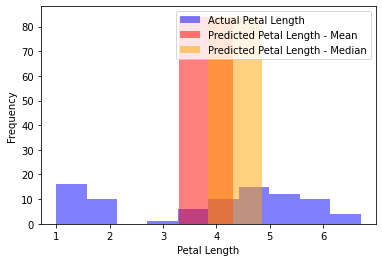

In [44]:
plt.hist(y_train.petal_length, color='blue', alpha=.5, label="Actual Petal Length")
plt.hist(y_train.petal_length_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Petal Length - Mean")
plt.hist(y_train.petal_length_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Petal Length - Median")
plt.xlabel("Petal Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### LinearRegression (OLS)

In [45]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train.petal_length)

y_train['petal_length_pred_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.petal_length, y_train.petal_length_pred_lm) ** (1/2)
y_validate['petal_length_pred_lm'] = lm.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.petal_length, y_validate.petal_length_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.2547884822984336 
Validation/Out-of-Sample:  0.23168569049149015


#### Lasso Lars 

In [46]:
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train.petal_length)


y_train['petal_length_pred_lars'] = lars.predict(X_train)


rmse_train = mean_squared_error(y_train.petal_length, y_train.petal_length_pred_lars) ** 0.5
y_validate['petal_length_pred_lars'] = lars.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.petal_length, y_validate.petal_length_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  1.7085154208583127 
Validation/Out-of-Sample:  1.7520687480687462


#### Tweedie Regressor (GLM)

In [47]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train, y_train.petal_length)

y_train['petal_length_pred_glm'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.petal_length, y_train.petal_length_pred_glm) ** 0.5
y_validate['petal_length_pred_glm'] = glm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.petal_length, y_validate.petal_length_pred_glm) ** 0.5

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.245949987690825 
Validation/Out-of-Sample:  0.20877591141886903


#### Plotting Model Predictions Errors

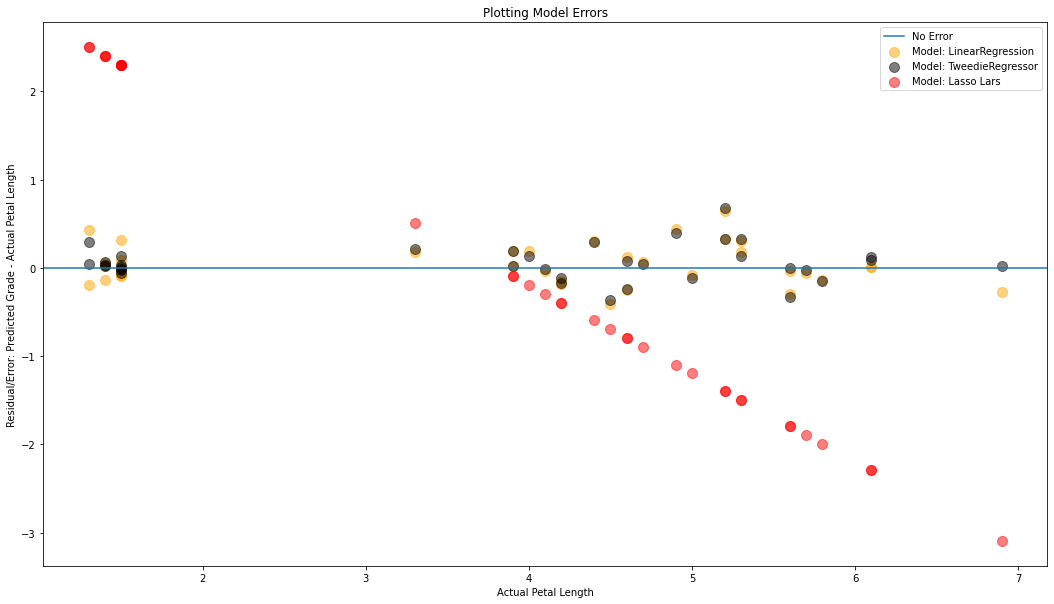

In [58]:
plt.figure(figsize=(18,10))
plt.axhline(label="No Error")
plt.scatter(y_validate.petal_length, y_validate.petal_length_pred_lm - y_validate.petal_length, 
            alpha=.5, color="orange", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.petal_length, y_validate.petal_length_pred_glm - y_validate.petal_length, 
            alpha=.5, color="black", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.petal_length, y_validate.petal_length_pred_lars - y_validate.petal_length, 
            alpha=.5, color="red", s=100, label="Model: Lasso Lars")
plt.legend()
plt.xlabel("Actual Petal Length")
plt.ylabel("Residual/Error: Predicted Grade - Actual Petal Length")
plt.title("Plotting Model Errors")
plt.show()

#### Histogram of best Model vs Baseline

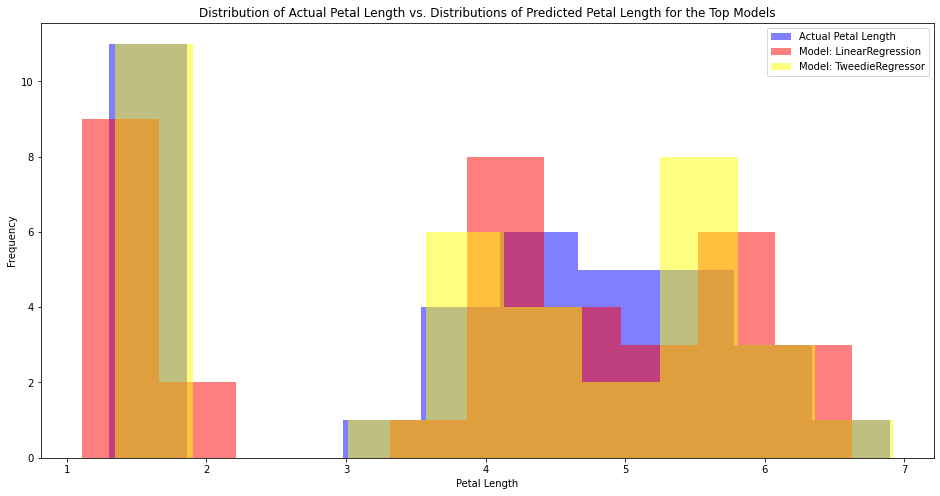

In [62]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.petal_length, color='blue', alpha=.5, label="Actual Petal Length")
plt.hist(y_validate.petal_length_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.petal_length_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")

plt.xlabel("Petal Length")
plt.ylabel("Frequency")
plt.title("Distribution of Actual Petal Length vs. Distributions of Predicted Petal Length for the Top Models")
plt.legend()
plt.show()

#### Testing out Test dataset with Tweedie Regressor

In [64]:
y_test.head()

73     4.9
113    5.5
133    5.6
89     4.1
38     1.4
Name: petal_length, dtype: object

In [65]:
y_test['petal_length_pred_glm'] = glm.predict(X_test)

rmse_test = mean_squared_error(y_test.petal_length, y_test.petal_length_pred_glm) ** 0.5
print("RMSE for TweedieRegressor\nOut-of-Sample Performance: ", rmse_test)

AttributeError: 'Series' object has no attribute 'petal_length'